https://www.kaggle.com/code/mineshjethva/image-segmentation-using-unet

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rrk3k0zr
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-rrk3k0zr
  Resolved https://github.com/tensorflow/examples.git to commit e78dbcfaa47a6688db12876b633fc465b42e15f4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1685466055.1321937735532275580295874947037829580191563650548-py3-none-any.whl size=300010 sha256=dff01be2d3094bec7f5ff90a1c2ef8abc133d94eda0fb3cc418c5b2342486464
  Stored in directory: /tmp/pip-ephem-wheel-cache-ei_bt5ph/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 53.2 MB/s eta 0:00:0000:0100:01


In [2]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpepbbbjz6tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [6]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [11]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [12]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

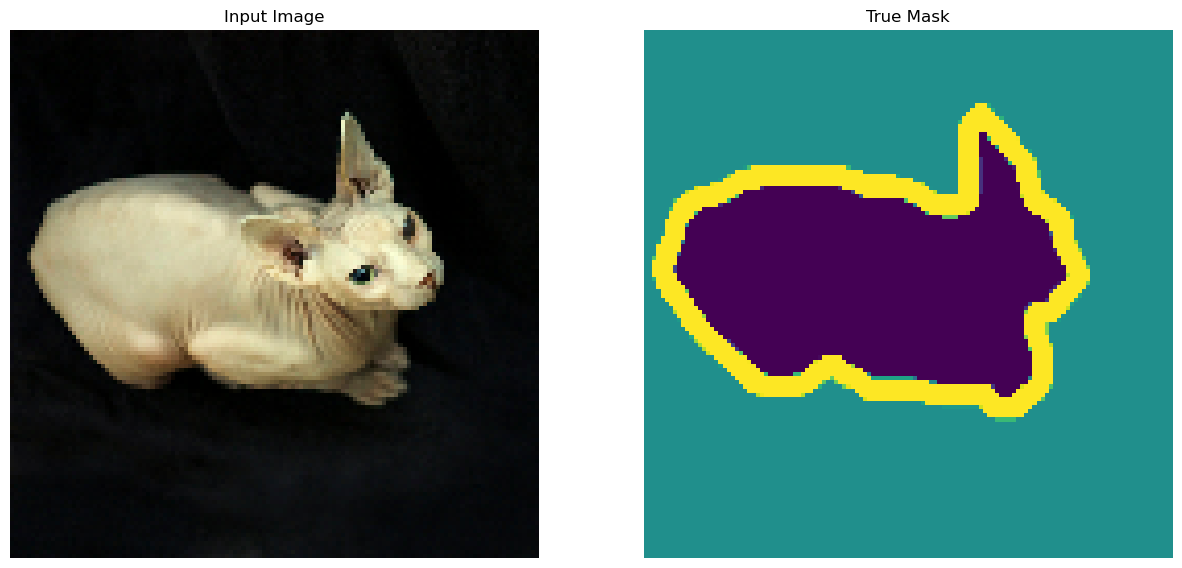

In [14]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [15]:
sample_image.shape

TensorShape([128, 128, 3])

In [16]:
OUTPUT_CHANNELS = 3

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [22]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 8s 8s/step


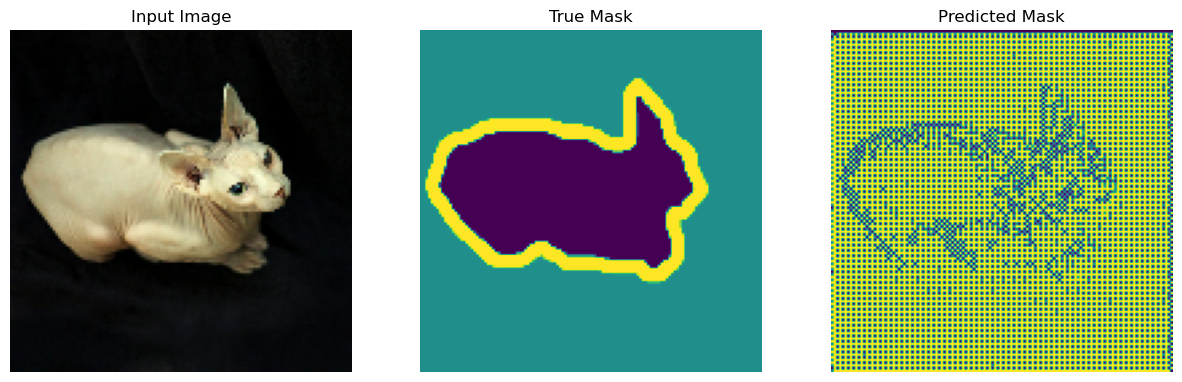

In [24]:
show_predictions()

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 23ms/step


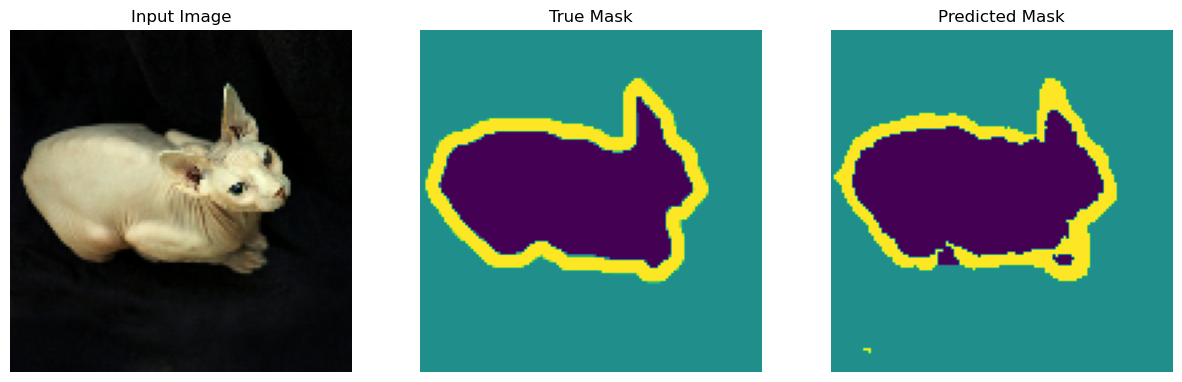


Sample Prediction after epoch 10

57/57 [==============================] - 7s 123ms/step - loss: 0.1775 - accuracy: 0.9213 - val_loss: 0.2865 - val_accuracy: 0.8875


In [30]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

2/2 [==============================] - 0s 19ms/step


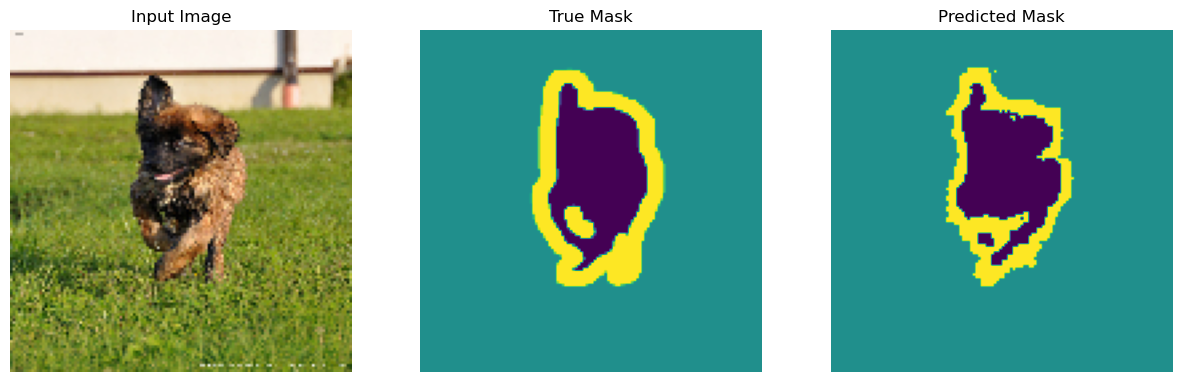

2/2 [==============================] - 0s 19ms/step


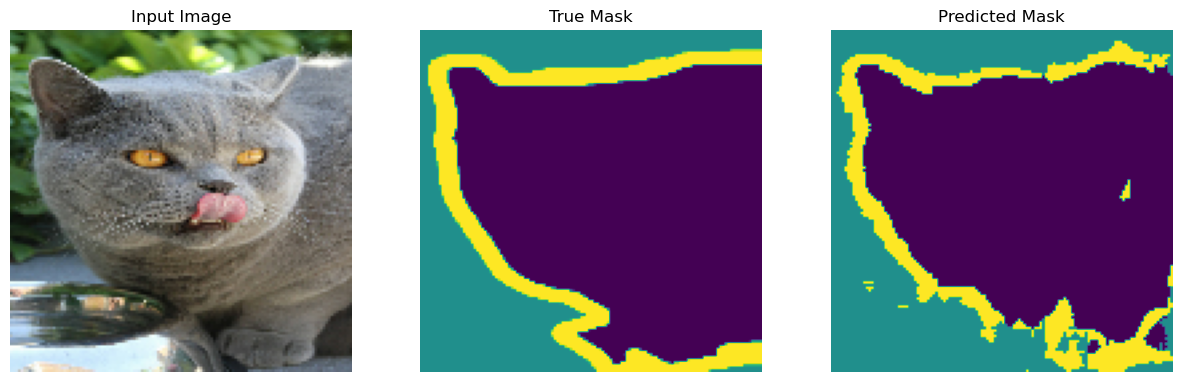

2/2 [==============================] - 0s 18ms/step


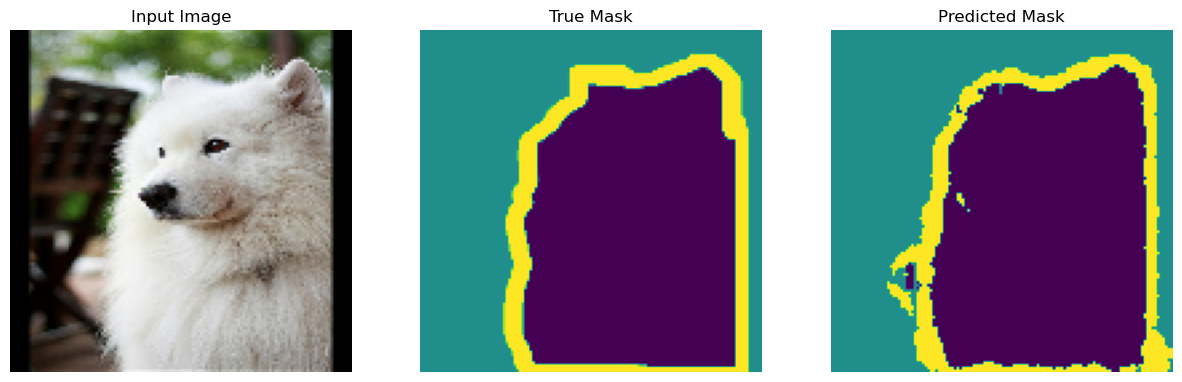

In [31]:
show_predictions(test_dataset, 3)

In [32]:
iou_scores = []
import numpy as np

for image, mask in test_dataset:
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    intersection = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

mean_iou_mob = np.mean(iou_scores)
print("Mean IoU:", mean_iou_mob)

1/1 [==============================] - 0s 42ms/step
Mean IoU: 0.6605203925111232


# RESNET101

In [33]:
base_model = tf.keras.applications.ResNet101(input_shape=[128, 128, 3], include_top=False)

# Print available layer names
for layer in base_model.layers:
    print(layer.name)

# Use the correct layer names for feature extraction
layer_names = [
    'conv1_relu',            # 64x64
    'conv2_block3_out',      # 32x32
    'conv3_block4_out',      # 16x16
    'conv4_block23_out',     # 8x8
    'conv5_block3_out',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

171446536/171446536 [==============================] - 1s 0us/step
input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_

In [34]:
down_stack.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [35]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [36]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [37]:
model_resnet = unet_model(OUTPUT_CHANNELS)
model_resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 64, 64, 64)  42658176    ['input_4[0][0]']                
                                , (None, 32, 32, 25                                               
                                6),                                                               
                                 (None, 16, 16, 512                                               
                                ),                                                          

In [40]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [41]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_resnet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_resnet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


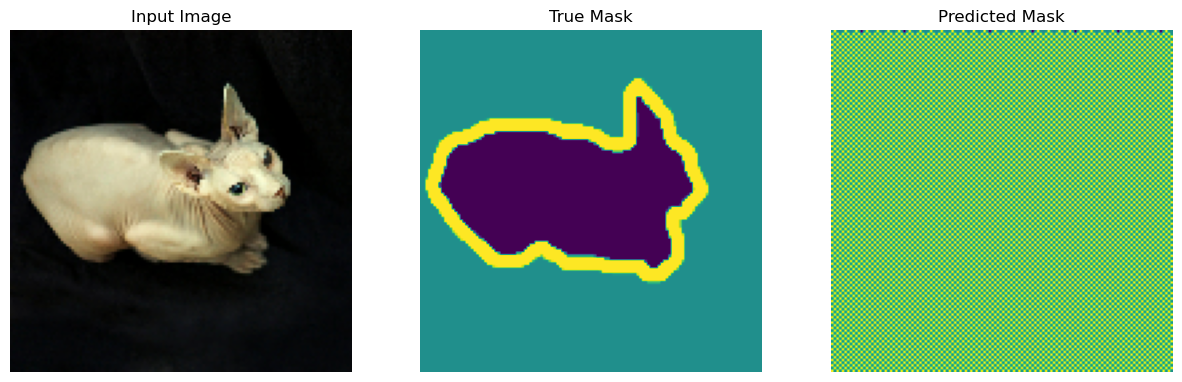

In [42]:
show_predictions()

In [43]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 28ms/step


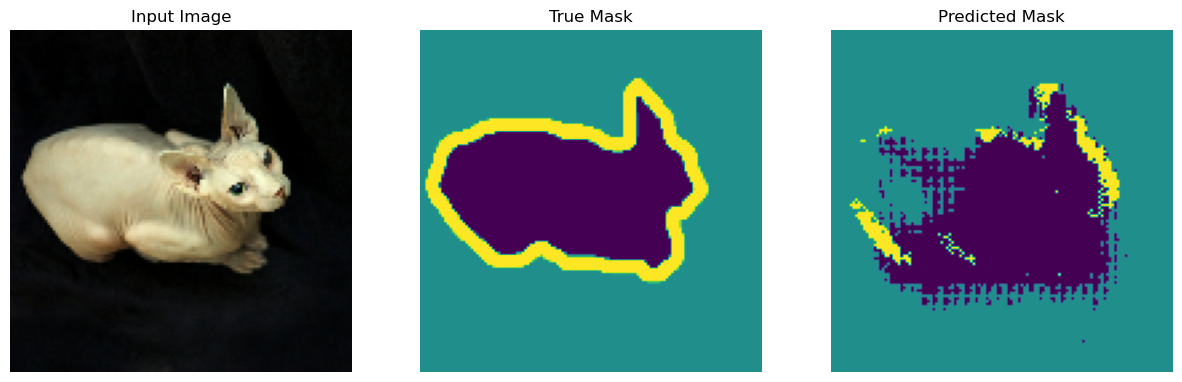


Sample Prediction after epoch 10

57/57 [==============================] - 10s 177ms/step - loss: 0.5811 - accuracy: 0.7579 - val_loss: 0.6241 - val_accuracy: 0.7458


In [44]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_resnet_history = model_resnet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

2/2 [==============================] - 0s 55ms/step


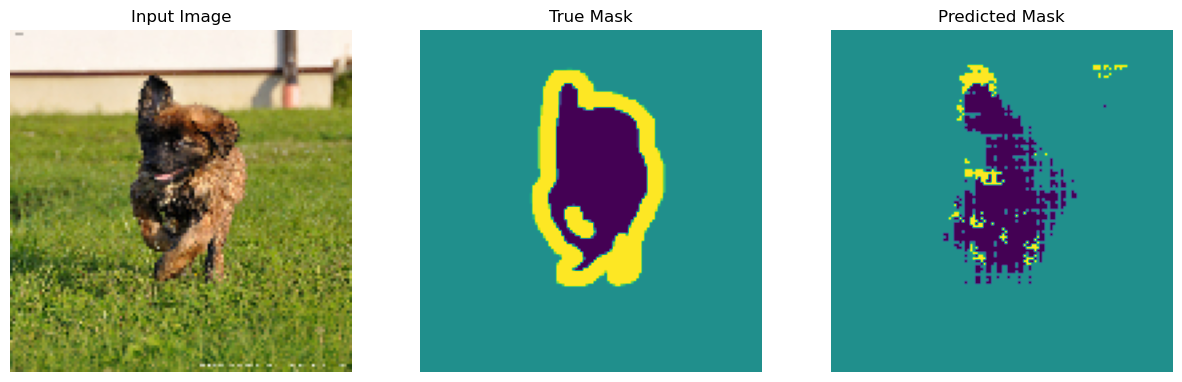

2/2 [==============================] - 0s 48ms/step


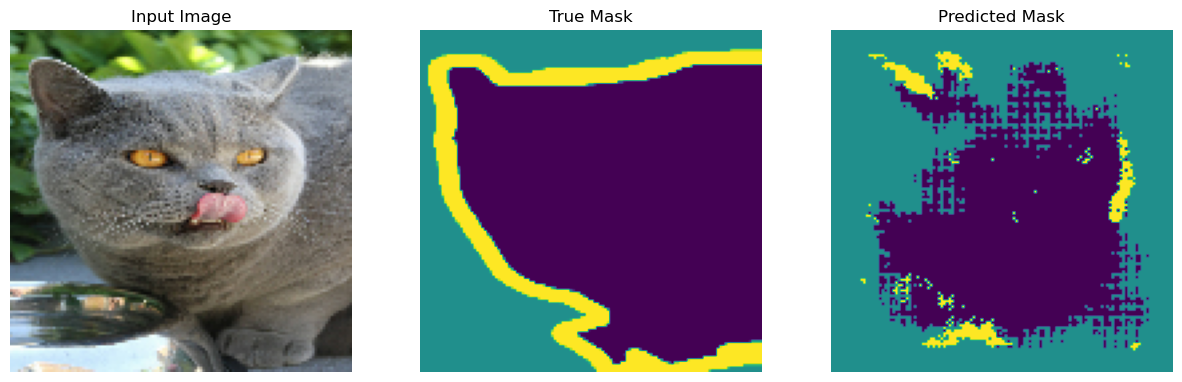

2/2 [==============================] - 0s 48ms/step


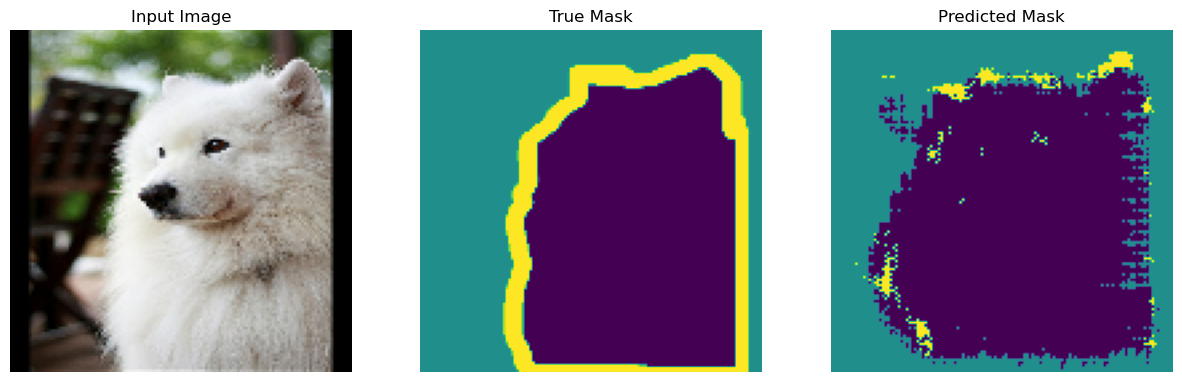

In [45]:
show_predictions(test_dataset, 3)

In [46]:
iou_scores = []

for image, mask in test_dataset:
    pred_mask = model_resnet.predict(image)
    pred_mask = create_mask(pred_mask)
    intersection = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

mean_iou_res = np.mean(iou_scores)
print("Mean IoU:", mean_iou_res)

1/1 [==============================] - 1s 518ms/step
Mean IoU: 0.6898031040804826


# EfficientB0

In [47]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [48]:
import tensorflow as tf
import efficientnet.tfkeras as efficientnet

# Load the EfficientNet base model
base_model = efficientnet.EfficientNetB0(input_shape=[128, 128, 3], include_top=False)

# Define the layer names for feature extraction
layer_names = [
    'block2a_expand_activation',  # 64x64
    'block3a_expand_activation',  # 32x32
    'block4a_expand_activation',  # 16x16
    'block6a_expand_activation',  # 8x8
    'top_activation',             # 4x4
]

# Retrieve the desired layers from the EfficientNet model
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Set the feature extraction model as non-trainable
down_stack.trainable = False

16804768/16804768 [==============================] - 0s 0us/step


In [49]:
down_stack.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 32)   864         ['input_5[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 32)   0           ['stem_bn[0][0]']          

In [50]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [51]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  # 64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [52]:
model_eff = unet_model(OUTPUT_CHANNELS)
model_eff.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_eff.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           [(None, 64, 64, 96)  4049564     ['input_6[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 240                                               
                                ),                                                          

In [53]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [54]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model_eff.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model_eff.predict(sample_image[tf.newaxis, ...]))])

In [55]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 43ms/step


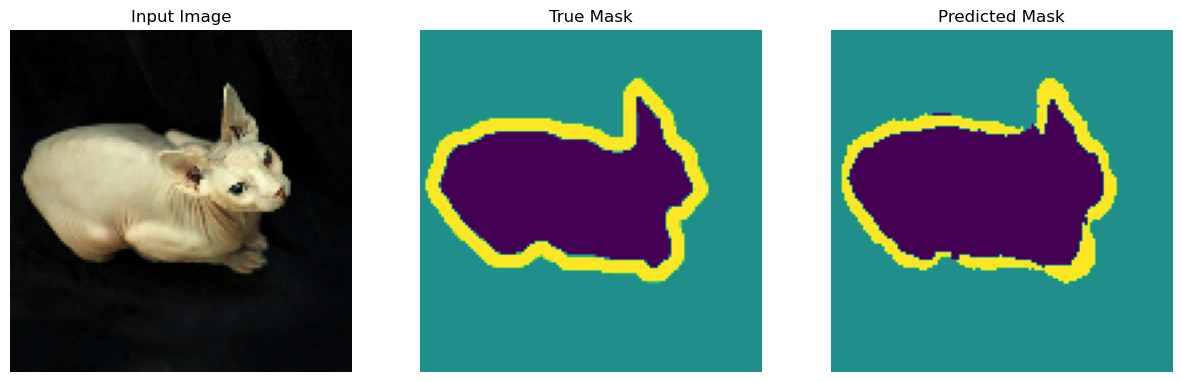


Sample Prediction after epoch 10

57/57 [==============================] - 8s 144ms/step - loss: 0.1734 - accuracy: 0.9230 - val_loss: 0.3278 - val_accuracy: 0.8840


In [56]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model_eff.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

2/2 [==============================] - 1s 23ms/step


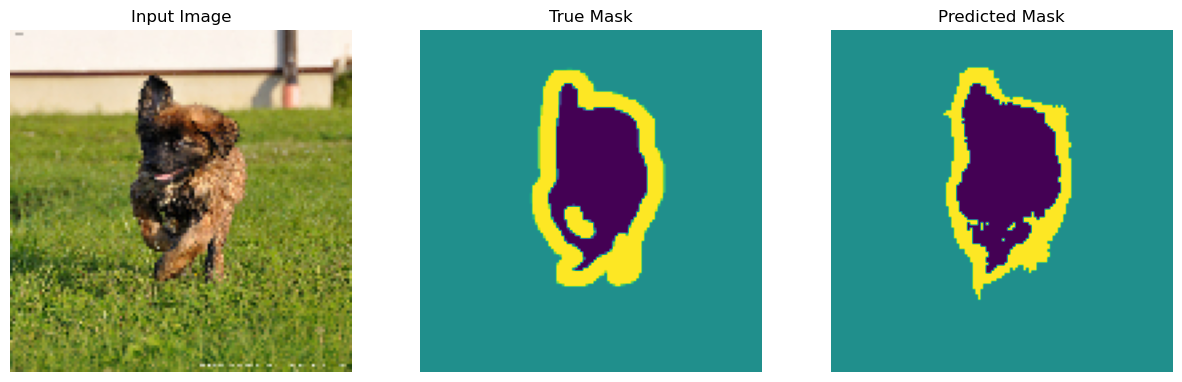

2/2 [==============================] - 0s 27ms/step


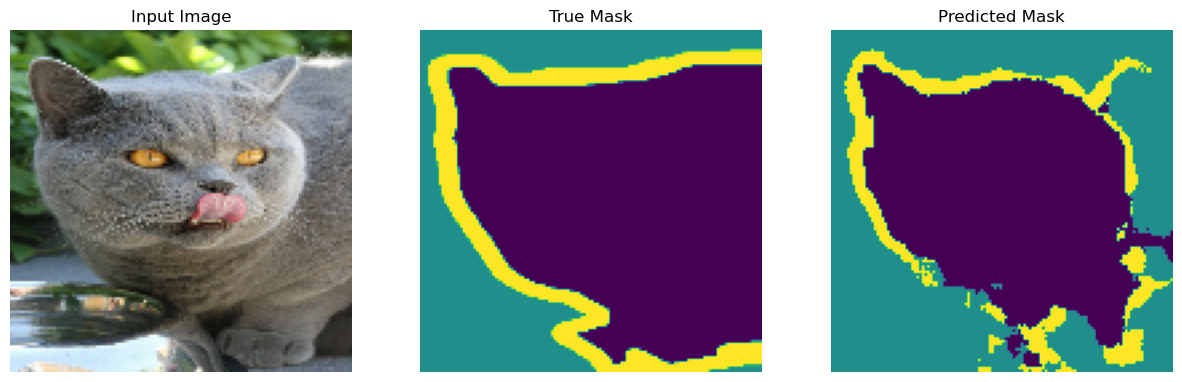

2/2 [==============================] - 0s 26ms/step


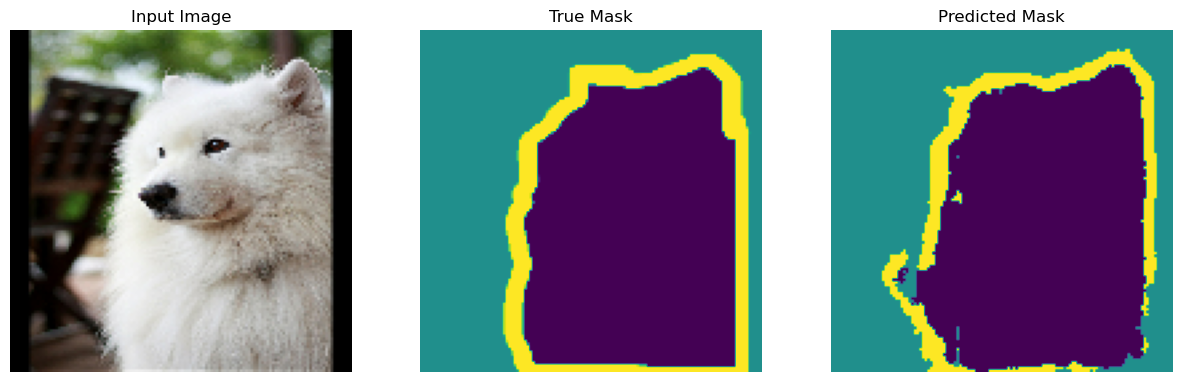

2/2 [==============================] - 0s 25ms/step


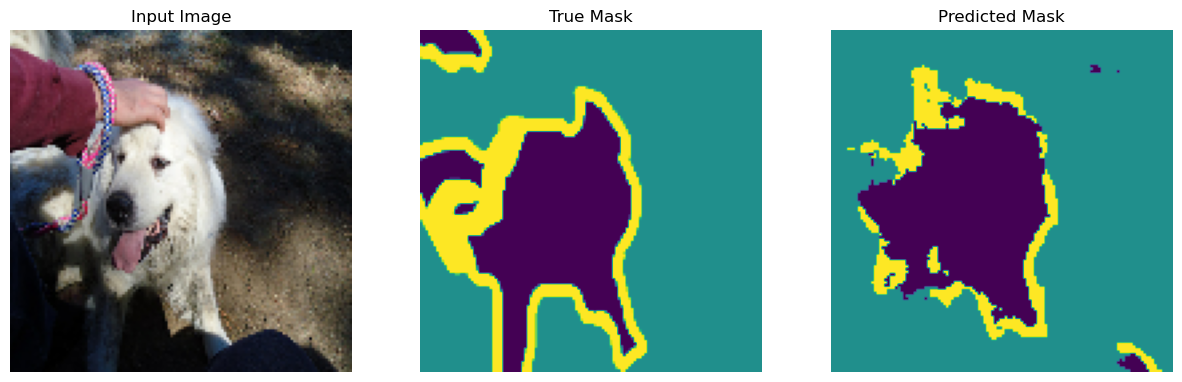

In [57]:
show_predictions(test_dataset, 4)

In [58]:
iou_scores = []

for image, mask in test_dataset:
    pred_mask = model_eff.predict(image)
    pred_mask = create_mask(pred_mask)
    intersection = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

mean_iou_eff = np.mean(iou_scores)
print("Mean IoU:", mean_iou_eff)


1/1 [==============================] - 0s 444ms/step
Mean IoU: 0.6579618339768258


# DenseNet121

In [59]:
# DenseNet
base_model = tf.keras.applications.DenseNet121(input_shape=[128, 128, 3], include_top=False)
layer_names = [
    'conv1/relu',       # 64x64
    'pool2_relu',       # 32x32
    'pool3_relu',       # 16x16
    'pool4_relu',       # 8x8
    'relu',             # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [60]:
down_stack.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_7[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']       

In [61]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [62]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  # 64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [63]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  # 64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [64]:
model_dense = unet_model(OUTPUT_CHANNELS)
model_dense.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dense.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           [(None, 64, 64, 64)  7037504     ['input_8[0][0]']                
                                , (None, 32, 32, 25                                               
                                6),                                                               
                                 (None, 16, 16, 512                                               
                                ),                                                          

In [65]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model_dense.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model_dense.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


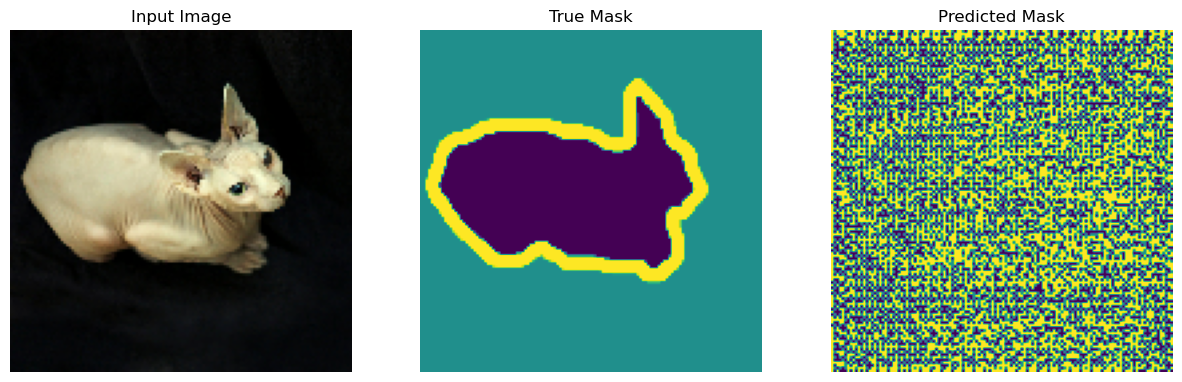

In [66]:
show_predictions()

In [67]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 31ms/step


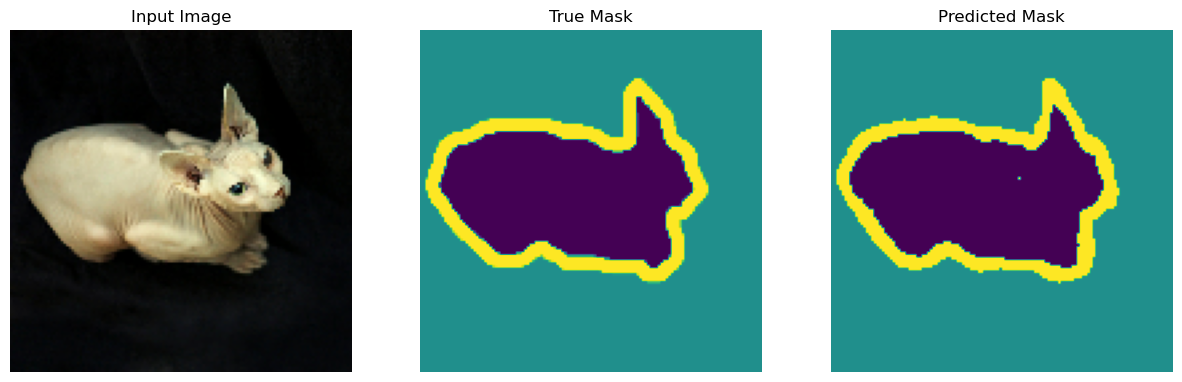


Sample Prediction after epoch 10

57/57 [==============================] - 8s 148ms/step - loss: 0.0988 - accuracy: 0.9531 - val_loss: 0.3698 - val_accuracy: 0.8930


In [72]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model_dense.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

2/2 [==============================] - 0s 36ms/step


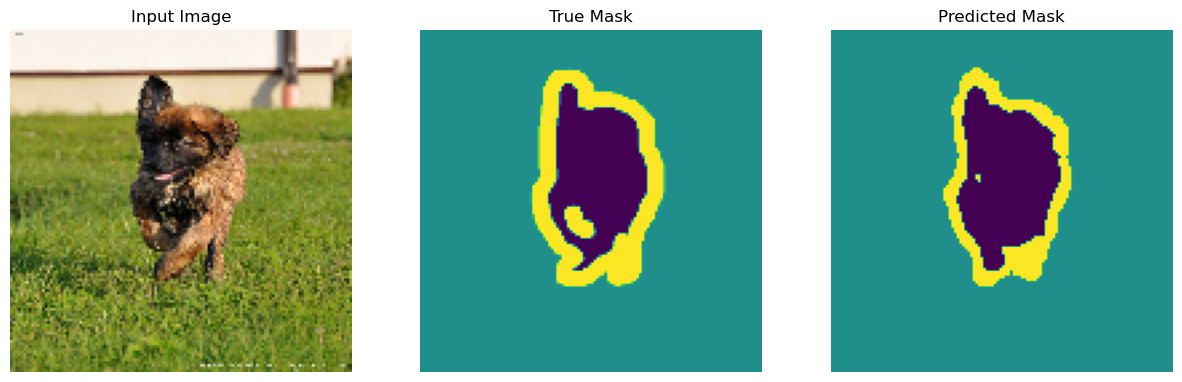

2/2 [==============================] - 0s 36ms/step


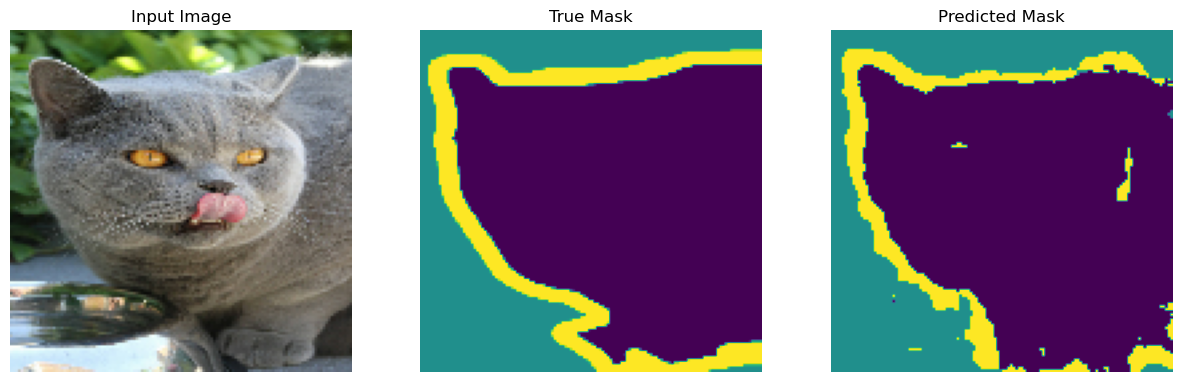

2/2 [==============================] - 0s 36ms/step


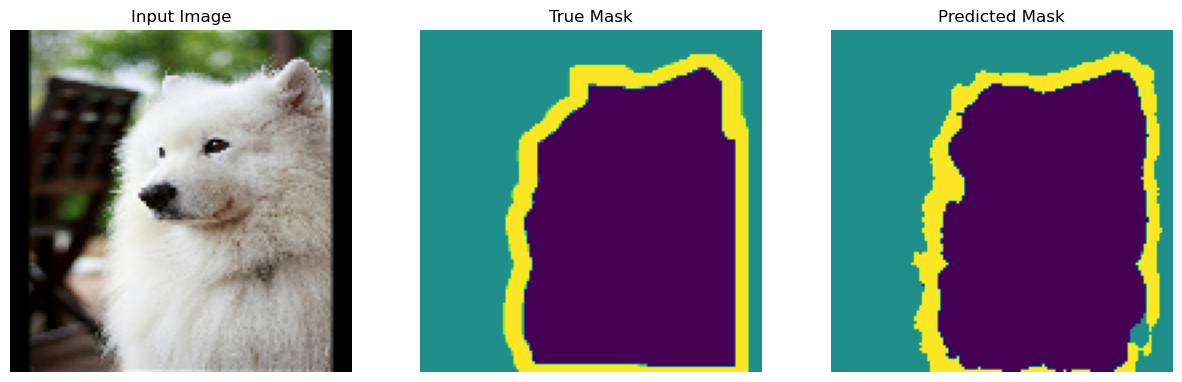

2/2 [==============================] - 0s 34ms/step


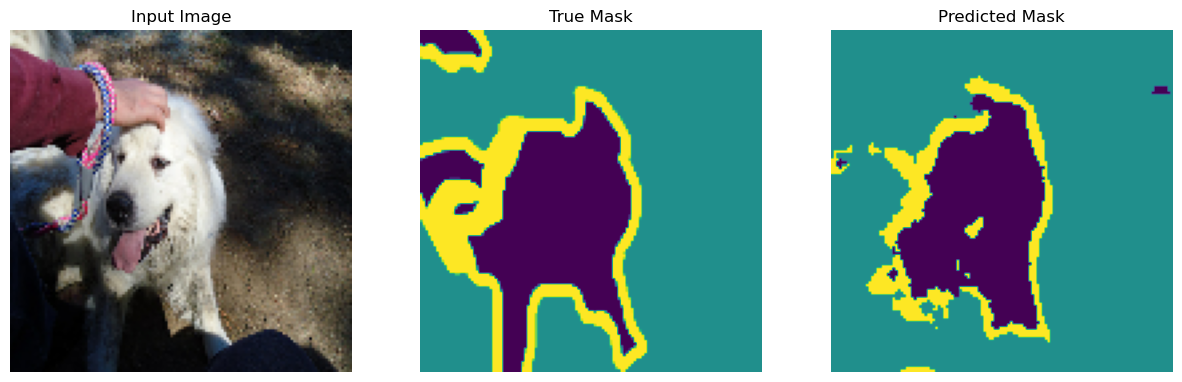

In [73]:
show_predictions(test_dataset, 4)

In [74]:
iou_scores = []

for image, mask in test_dataset:
    pred_mask = model_dense.predict(image)
    pred_mask = create_mask(pred_mask)
    intersection = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

mean_iou_dense = np.mean(iou_scores)
print("Mean IoU:", mean_iou_dense)

1/1 [==============================] - 0s 31ms/step
Mean IoU: 0.6563010726569387


                         IoU
Model ResNet        0.689803
Model Densenet      0.656301
Model EfficientNet  0.657962
Model MobileNet     0.660520


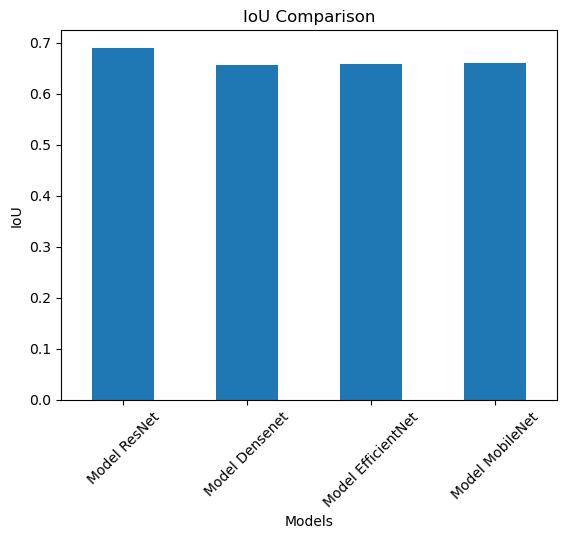

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# IoU values for each model
iou_values = {
    'Model ResNet': mean_iou_res,
    'Model Densenet': mean_iou_dense,
    'Model EfficientNet': mean_iou_eff,
    'Model MobileNet': mean_iou_mob
}

# Create a DataFrame from the IoU values
df_iou = pd.DataFrame.from_dict(iou_values, orient='index', columns=['IoU'])

# Display the table
print(df_iou)

# Plot the IoU values
df_iou.plot(kind='bar', legend=False)
plt.xlabel('Models')
plt.ylabel('IoU')
plt.title('IoU Comparison')
plt.xticks(rotation=45)
plt.show()
